<a href="https://colab.research.google.com/github/RubenMcCarty/Deep-Learning-RQ/blob/main/8_metricas_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métricas para Clasificación Binaria
# [MSc. Ruben Quispe](https://www.linkedin.com/in/ruben-quispe-l/)

En lab anteriores hemos visto como podemos implementar modelos lineales para clasficación binaria, ejemplos de los modelos más simples en el `Machine Learning` pero no por ello menos usados (pese a las limitaciones que ya hemos comentado, estos modelos son eficientes y explicables, lo cual es preferido en multitud de aplicaciones). En este post vamos a ver algunas de las métricas más utilizadas en clasificación binaria (aunque pueden extenderse también a clasificación en varias clases). Estas métricas nos van a ser muy útiles para caracterizar el desempeño de nuestros modelos y comparar diferentes modelos entre sí para, por ejemplos, utilizar el mejor. 

## El dataset MNIST

En los posts anteriores sobre clasificación binaria hemos trabajado con el dataset Iris para clasificación de flores a partir de características como el ancho o la longitud de sus pétalos. En este post vamos a utilizar un nuevo dataset, probablemente el más utilizado mientras aprendemos sobre `Deep Learning` y considerado el *hello world* del `Machine Learning`: el dataset [MNIST](http://yann.lecun.com/exdb/mnist/). Este dataset fue elaborado con el objetivo de entrenar modelos automáticos de OCR (*Optical Character Recognition*) para poder acelerar el trabajo de clasificación de correo a partir del código postal escrito. Está formado por 70,0000 imágenes de dígitos manuscritos, entre $0$ y $9$, y el objetivo es el de ser capaces de diseñar un algoritmo capaz de clasificar una imágen (decir que número es) directamente a partir de sus pixeles. De entre las diferentes fuentes que podemos utilizar para descargar estos datos, vamos a utilizar [Scikit-Learn](https://scikit-learn.org/stable/).

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

Como puedes ver, cada imágen está formada por $784$ características (los pixeles). Podemos visualizar unas cuantas imágenes junto a sus etiquetas de la siguiente manera para hacernos una idea del tipo de datos al que nos enfrentamos.

KeyError: ignored

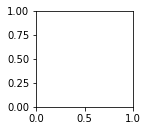

In [5]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y[ix])
plt.tight_layout()
plt.show()

Por último, vamos a extraer $60,000$ imágenes para entrenar nuestro modelo y $10,000$ para evaluarlo y calcular las diferentes métricas que veremos.

In [6]:
X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000], y[60000:]

> 💡 Recuerda que para que nuestro modelo pueda aprender mejor tenemos que normalizar los datos que usaremos como entrada. En este caso cada píxel está representado por un valor entero entre 0-255, por lo que al dividir cada imágen por 255 nos aseguramos que nuestros valores a la entrada estén en el rango 0-1

## Entrenando un clasificador binario

Para llevar a cabo una tarea de clasificación binaria necesitamos que nuestro dataset esté dividido en dos clases, sin embargo el dataset MNIST, cómo ya hemos visto, tiene $10$ clases (todos los dígitos entre $0$ y $9$). En este caso vamos entrenar un modelo para clasificar las imágenes con el número $5$ del resto.

In [7]:
import numpy as np

y_train_5 = (y_train == '5').astype(np.int)
y_test_5 = (y_test == '5').astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

Y ahora traemos el modelo de Regresión Logística que implementamos en el [post](https://sensioai.com/blog/015_logistic_regression) anterior. Si no estás familiarizado con este modelo te recomiendo que le eches un vistazo al post antes de seguir. En este caso hemos cambiado el esquema de inicialización de los pesos, utilizando una distribución normal escalada por el número de pesos. También hemos añadido un `print` para ver cómo va evolucionando el modelo durante el entrenamiento, visualizando el valor de la *loss function* en cada *epoch*.

In [8]:
def bce(y, y_hat):
    return - np.mean(y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat))

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class Perceptron():
  def __init__(self, size):
    self.w = np.random.normal(loc=0.0, 
          scale = np.sqrt(2/(size+1)), 
          size = (size, )) 
    self.ws = []
    self.activation = sigmoid
    self.loss = bce
    
  def __call__(self, w, x):
    return self.activation(np.dot(x, w)) 

  def fit(self, x, y, epochs, lr, verbose=True):
    x = np.c_[np.ones(len(x)), x]
    for epoch in range(1,epochs+1):
        # Batch Gradient Descent
        y_hat = self(self.w, x)  
        # función de pérdida
        l = self.loss(y, y_hat)
        # derivadas
        dldh = (y_hat - y)
        dhdw = x
        dldw = np.dot(dldh, dhdw)
        # actualizar pesos
        self.w = self.w - lr*dldw
        # guardar pesos para animación
        self.ws.append(self.w.copy())
        # print loss
        if verbose:
            print(f"Epoch {epoch}/{epochs} Loss {l}")


In [9]:
np.random.seed(42)

perceptron = Perceptron(X.shape[1] + 1)
epochs, lr = 10, 1e-5
perceptron.fit(X_train, y_train_5, epochs, lr)

Epoch 1/10 Loss -0.5548410142855111
Epoch 2/10 Loss 0.7206598224991342
Epoch 3/10 Loss 0.5304482677090387
Epoch 4/10 Loss 0.3387412138758058
Epoch 5/10 Loss 0.14817873671774542
Epoch 6/10 Loss 0.029990518845371097
Epoch 7/10 Loss 0.07018573941348819
Epoch 8/10 Loss 0.039571156934180785
Epoch 9/10 Loss 0.053798900444024335
Epoch 10/10 Loss 0.04198956554028167


En este punto ya hemos entrenado nuestro modelo. Ahora, ¿cómo lo podemos evaluar? ¿Es este un buen modelo o un mal modelo? ¿Si entrenamos otro modelo, cómo podemos saber si es mejor o pero que el primero? Todas estas preguntas las podemos responder con las `métricas`.

## Métricas

Vamos a ver las métricas más utilizadas en la evaluación de modelos de clasificación binaria. Para calcular cualquier métrica vamos a necesitar ser capaces de generar predicciones con nuestro modelo. En posts anterior ya hemos visto cómo podemos hacerlo.

In [10]:
def evaluate(perceptron, x, t = 0.5):
    w = perceptron.ws[-1]
    x = np.c_[np.ones(len(x)), x]
    y = perceptron(w, x)
    return (y > t).astype(np.int)

### *Accuracy*

La primera métrica que vamos a ver, también la más común, es la *accuracy* (o precisión). En esta métrica simplemente contamos todos los elementos del dataset que nuestro modelo ha sido capaz de clasificar correctamente y lo dividimos entre el número total de elementos. Ésto implica que la precisión será un valor entre $0$ y $1$, significando $0$ que nuestro modelo no ha acertado ningún resultado y $1$ que los ha acertado todos. También es común dar este valor en porcentaje (simplemente multiplicando por $100$ el resultado anterior).

In [11]:
def accuracy(y_pred, y):
    return np.sum(y_pred == y) / len(y)

In [12]:
y_pred = evaluate(perceptron, X_train)
accuracy(y_pred, y_train_5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


0.9196666666666666

In [13]:
y_pred = evaluate(perceptron, X_test)
accuracy(y_pred, y_test_5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


0.9232

Cómo podemos ver nuestro modelo tiene una precisión cercana al $92 \%$ tanto para el conjunto de entrenamiento como para el de evaluación. ¿Es este un buen modelo? A priori podríamos pensar que si, ya que nuestro modelo acierta $9$ de cada $10$ imágenes... Sin embargo, la realidad es que nuestro modelo no está haciendo prácticamente nada. Vamos a ver porqué analizando nuestros datos. Cómo ya hemos comentado estamos haciendo un clasificador binario para detectar el número $5$. ¿Cuántas imágenes diferentes de $5$s tenemos en nuestro dataset?

In [14]:
1 - y_train_5.mean(), 1 - y_test_5.mean()

(0.90965, 0.9108)

Aquí tenemos la respuesta, nuestro dataset está formado en un $91 \%$ por imágenes que no son $5$. Esto significa que un modelo *naive* que siempre diga que NO tenemos un $5$ va a tener una *accuracy* del $91 \%$. Sin embargo, en el mundo real, nunca detectaremos este dígito y nuestra aplicación fallará estrepitosamente. Nuestro modelo tiene una precisión del $92 \%$, mejorando ligreamente este valor pero no por mucho.

KeyError: ignored

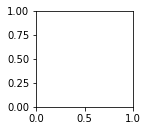

In [15]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        fives = (y_test_5 == 1)
        ix = random.randint(0, len(X_test[fives])-1)
        img = X_test[fives][ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        y_pred = evaluate(perceptron, [img])
        plt.title(f"{y_test_5[fives][ix]} / {y_pred[0]}", color="red" if y_test_5[fives][ix] != y_pred[0] else "green")
plt.tight_layout()
plt.show()

Como puedes ver la métrica de precisión es muy útil pero puede llevar a engaños. Esto se hace especialmente patente en aplicaciones en las que tenemos muy pocas muestras de la clase que queremos capturar. Un ejemplo claro es el de detección de transacciones bancarias fraudulentas, que representan cerca del 0.001% del total de operaciones realizadas. Un modelo de clasificación binaria que siempre diese como resultado que una transacción NO es fraudulenta tendría una precisión del 99.999%, sin embargo sería un modelo totalmente inútil en el mundo real.

> ⚡ Siempre es recomendable tener unas primeras métricas `baseline` con las que comparar nuestros modelos. Estas métricas pueden obtenerse con un modelo aleatorio (antes de ser entrenado) o en el caso de la clasificación podemos utilizar directamente la distribución de clases en el dataset. Cualquier modelo que hagamos debería mejorar estas métricas.

En este caso en particular podemos obtener un mejor modelo simplemente entrenando durante más epochs (el modelo anterior no había convergido).

In [16]:
perceptron = Perceptron(X.shape[1] + 1)
epochs, lr = 300, 1e-5
perceptron.fit(X_train, y_train_5, epochs, lr, verbose=False)
y_pred = evaluate(perceptron, X_test)
accuracy(y_pred, y_test_5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


0.9693

KeyError: ignored

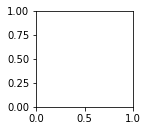

In [17]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        fives = (y_test_5 == 1)
        ix = random.randint(0, len(X_test[fives])-1)
        img = X_test[fives][ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        y_preds = evaluate(perceptron, [img])
        plt.title(f"{y_test_5[fives][ix]} / {y_preds[0]}", color="red" if y_test_5[fives][ix] != y_preds[0] else "green")
plt.tight_layout()
plt.show()

Todas las métricas que vamos a ver están implementadas en la librería `Scikit Learn`, por lo que te recomiendo que las uses directamente para evitar errores en la implementación.

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_5, y_pred)

0.9693

### La Matriz de Confusión

Una matriz de confusión nos va a indicar exactamente cuales son los puntos fuertes y débiles de nuestro clasificador. Para cada clase, vamos a calcular cuantos elementos han sido bien clasificados por nuestro modelo y cuántos han sido confundidos con otras clases (esta matriz nos será muy útil en clasificación en varias clases también).

In [19]:
TP = np.sum((y_pred == 1) & (y_test_5 == 1)) 
TN = np.sum((y_pred == 0) & (y_test_5 == 0)) 
FP = np.sum((y_pred == 1) & (y_test_5 == 0))
FN = np.sum((y_pred == 0) & (y_test_5 == 1))

CM = [[TN, FP],
      [FN, TP]]
CM

[[9038, 70], [237, 655]]

En esta matriz podemos observar:
    
- Verdaderos Positivos (TP, *True Positives*): elementos que nuestro modelo clasifica correctamente como la clase que nos interesa, la clase positiva (fila 1, columna 1).
- Verdaderos Negativos (TN, *True Negatives*): elementos que nuestro modelo clasifica correctamente como la clase negativa (fila 0, columna 0).
- Falsos Positivos (FP, *False Positives*): elementos que nuestro modelo clasifica erróneamente como la clase positiva (fila 0, columna 1).
- Falsos Negativos (FN, *False Negatives*): elementos que nuestro modelo clasifica erróneamente como la clase negativa (fila 1, columna 0).

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_5, y_pred)

array([[9038,   70],
       [ 237,  655]])

> 💡 Una vez vistos los conceptos definidos en este apartado podemos reescribir la *accuracy* como $ accuracy = \frac{TP + TN}{TP+TN+FP+FN} $

### *Precision* y *Recall*

Hemos visto la confusión a la que nos puede llevar una métrica simple como la *accuracy*. Ahora veremos dos métricas que un poco más informativas. Éstas son *precision* (no confundir con la precisión, en castellano, equivalente a la *accuracy*) y *recall*. Para definir estas métricas primero necesitamos definir los siguiente conceptos:

$$ precision = \frac{TP}{TP+FP} $$

$$ recall = \frac{TP}{TP+FN} $$

En la siguiente imágen puedes ver una visualización de estas métricas. *Precision* nos da una idea de cómo de propenso es nuestro modelo a dar falsos positivos. Un valor cercano a $1$ indicará que nuestro modelo apenas da falsos positivos (aunque puede seguir fallando dando falsos negativos) mientras que un valor cercano a $0$ indicará que nuestro modelo da muchos falsos positivos. Lo mismo aplica al *Recall*, pero en este caso aplicada a los falsos negativos. Un valor cercano a $1$ indicará que nuestro modelo apenas da falsos negativos (aunque puede seguir fallando dando falsos positivos) mientras que un valor cercano a $0$ indicará que nuestro modelo da muchos falsos negativos. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png)

In [21]:
def precision(y_pred, y):
    TP = np.sum((y_pred == 1) & (y == 1)) 
    FP = np.sum((y_pred == 1) & (y == 0))
    return TP / (TP + FP)

def recall(y_pred, y):
    TP = np.sum((y_pred == 1) & (y == 1)) 
    FN = np.sum((y_pred == 0) & (y == 1))
    return TP / (TP + FN)

In [22]:
y_pred = evaluate(perceptron, X_test)
precision(y_pred, y_test_5), recall(y_pred, y_test_5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


(0.903448275862069, 0.734304932735426)

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test_5, y_pred), recall_score(y_test_5, y_pred)

(0.903448275862069, 0.734304932735426)

En función de la aplicación en la que estemos trabajando vamos a querer optimizar una métrica u otra. En aplicaciones en las que tener falsos positivos sea perjudicial (por ejemplo, aplicaciones de seguridad) querremos modelos con un buena *precision*, mientras que en aplicaciones en las que tener falsos negativos sea perjudicial (por ejemplo, sistemas de diagnóstico médico) querremos modelos con buen *recall*. Una vez nuestro modelo ha sido entrenado, podemos ajustar estas métricas variando el valor del *threshold* utilizado en la evaluación. A esto se le conoce como el *precision-recall trade off*.

In [24]:
for t in np.linspace(0.1,0.9,20):
    y_pred = evaluate(perceptron, X_test, t)
    print(f"Threshold: {t:.3f} Precision {precision(y_pred, y_test_5):.4f} Recall {recall(y_pred, y_test_5):.4f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


Threshold: 0.100 Precision 0.5112 Recall 0.9193
Threshold: 0.142 Precision 0.5996 Recall 0.8980
Threshold: 0.184 Precision 0.6639 Recall 0.8879
Threshold: 0.226 Precision 0.7229 Recall 0.8688
Threshold: 0.268 Precision 0.7686 Recall 0.8453
Threshold: 0.311 Precision 0.8033 Recall 0.8240
Threshold: 0.353 Precision 0.8244 Recall 0.7948
Threshold: 0.395 Precision 0.8461 Recall 0.7825
Threshold: 0.437 Precision 0.8740 Recall 0.7623
Threshold: 0.479 Precision 0.8950 Recall 0.7455
Threshold: 0.521 Precision 0.9106 Recall 0.7197
Threshold: 0.563 Precision 0.9180 Recall 0.6906
Threshold: 0.605 Precision 0.9428 Recall 0.6648
Threshold: 0.647 Precision 0.9545 Recall 0.6357
Threshold: 0.689 Precision 0.9657 Recall 0.5998
Threshold: 0.732 Precision 0.9696 Recall 0.5717
Threshold: 0.774 Precision 0.9727 Recall 0.5202
Threshold: 0.816 Precision 0.9792 Recall 0.4753
Threshold: 0.858 Precision 0.9866 Recall 0.4114
Threshold: 0.900 Precision 0.9935 Recall 0.3453


Cómo se puede observar, incrementar el valor de una de las métricas implica que la otra va a disminuir (es por esto que se le llama *trade-off* ya que tenemos que llegar a un compromiso). Así pues, escogeremos un valor del *threshold* que se ajusto a los criterios de diseño de nuestra aplicación en particular (en función de la cantidad de falsos positivos y falsos negativos que estemos dispuestos a asumir).

![](https://wizardforcel.gitbooks.io/scikit-and-tensorflow-workbooks-bjpcjp/pics/decision-threshold-and-precision-vs-recall.png)

### F1-Score

Una métrica rápida que nos va a decir si nuestro modelo tiene buena *precision* y *recall* es el *F1-score*.

$$  F_1 = 2 \times \frac{precision \times recall}{precision + recall} $$

Es una métrica muy usada ya que aglutina la información de ambas métricas, sin embargo va a favorecer mucho aquellos modelos con un valor similar de *precision* y *recall*, lo cual ya hemos comentado que no es siempre lo que vamos a querer.

In [25]:
y_pred = evaluate(perceptron, X_test)

p = precision_score(y_test_5, y_pred)
r = recall_score(y_test_5, y_pred)

f1 = 2*(p*r)/(p+r)
f1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


0.8101422387136673

In [26]:
from sklearn.metrics import f1_score

f1_score(y_test_5, y_pred)

0.8101422387136673

### La curva ROC

Podemos visualizar rápidamente el comportamiento de un modelo para varios *thresholds* con la llamada curva ROC (*Receiver Operating Characteristic*). En ella representamos el ratio de verdaderos positivos (TPR) contra el ratio de falsos positivos (FPR), definidos de la siguiente manera:

$$ TPR = \frac{TP}{TP+FN} $$

$$ FPR = \frac{FP}{FP+TN} $$

In [27]:
def evaluate2(perceptron, x):
    w = perceptron.ws[-1]
    x = np.c_[np.ones(len(x)), x]
    y = perceptron(w, x)
    return y

In [28]:
from sklearn.metrics import roc_curve

y_pred2 = evaluate2(perceptron, X_test)
fpr, tpr, thresholds = roc_curve(y_test_5, y_pred2)

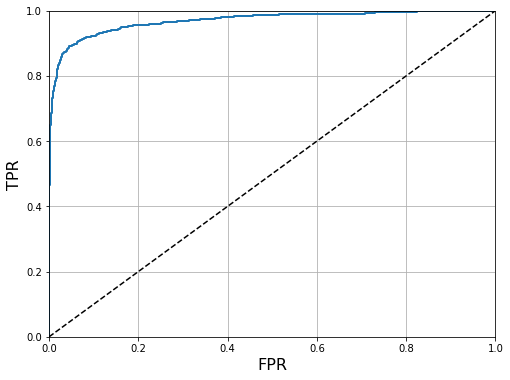

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('FPR', fontsize=16) 
    plt.ylabel('TPR', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)              
plt.show()

Una métrica muy utilizada para comparar clasificadores es el área bajo la curva ROC, ya que nos indica como de robusto es un modelo. La línea recta representa un modelo *naive* que podemos usar como baseline. Cómo puedes ver el área bajo la curva ROC de este modelo es de $0.5$, por lo que cualquier modelo que hagamos debería superar este valor. Cuánto más se acerque la curva a la esquina superior izquierda, mayor será el área y mejor será el modelo.

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_5, y_pred2)

0.9693789129351619

## Resumen

En este post hemos visto las métricas más comunes cuando trabajamos con clasificadores (tanto binarios como multi-clase). Para ello hemos trabajado con el dataset MNIST, uno de los datasets más utilizados en el `Machine Learning`. El objetivo es el de clasificar imágenes de dígitos manuscritos en 10 clases (desde el dígito 0 al 9), sin embargo lo hemos adaptado para hacer clasificación binaria de imágenes con el número 5. También hemos mejorado ligeramente la implementación de nuestro `Perceptrón` con una mejor inicialización de los pesos y la posibilidad de visualizar la evolución de la función de pérdida durante el entrenamiento. Después hemos visto las siguiente métricas:

- *Accuracy* es la más simple, consistente en contar cuantos elementos del dataset nuestro modelo clasifica correctamente. Puede llevarnos a engaños si no tenemos en cuenta la distribución de nuestras clases, poniendo en relevancia la necesidad de tener métricas `baseline` para comprar nuestros primeros modelos.
- La matriz de confusión nos va indicar el número de elementos del nuestro dataset que el modelo clasifica bien, así como todos los que confunda con otras clases. De esta manera sabremos cómo mejorar nuestro modelo.
- *Precision* y *Recall* nos indican cómo de robusto será nuestro modelo, cuantificando los falsos positivos y falsos negativos. En función de nuestra aplicación y su sensibilidad preferiremos una mejor métrica u otra (como hemos visto, mejorar una de ella implica empeorar la otra).
- El *F1-Score* nos dará una idea rápida de la robustez del modelo combinando las dos métricas anteriores.
- La curva *ROC*, y en especial el área debajo de la curva, será una muy buena manera de comparar modelos para poder elegir el que más se ajuste a nuestras necesidades.

Como podemos ver, evaluar un modelo va más allá de proporcionar un valor de precisión y dependerá en gran medida de la aplicación en cuestión y las condiciones reales a las que se vaya a enfrentar nuestro modelo en el mundo real. Monitorizar nuestros modelos constantemente nos permitirá mejorarlos de manera contínua así como encontrar posibles fallos, y para ello saber qué métricas son las importantes es fundamental.